In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%matplotlib inline
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [42]:
classes = ['negatives', 'positives']
num_classes = 2
resize_image = (32, 32)

### Reading data

In [43]:
def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis = 0).astype(np.float32)

def read_data(classes, num_classes):
    images = []
    labels = []
    
    #num_imgs_to_read = 10000
    
    
    for lbl in classes:
        #num_img = 0
        
        if lbl == 'positives':
            full_path = os.path.join('SMILEsmileD-master', 'SMILEs') + '/' + lbl + '/' + 'positives7' + '/'
            cls = 1
        else:
            full_path = os.path.join('SMILEsmileD-master', 'SMILEs') + '/' + lbl + '/' + 'negatives7' + '/'
            cls = 0
        
        print('reading folder: {}'.format(full_path))
        
        
        for img in glob.glob(full_path + '*.jpg'):
            
            #num_img += 1
            
            image = plt.imread(img)
            image = resize(image, resize_image, mode = 'reflect')
            image = image.astype(np.float32)
            
            label = np.zeros((num_classes, ), dtype = np.float32)
            label[cls] = 1.0
            
            images.append(image)
            labels.append(label)
            
            #if num_img == num_imgs_to_read:
                #break
            
    return to_tf_format(images).astype(np.float32), np.matrix(labels).astype(np.float32)

In [44]:
X, y = read_data(classes, num_classes)

reading folder: SMILEsmileD-master/SMILEs/negatives/negatives7/


/home/monu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


reading folder: SMILEsmileD-master/SMILEs/positives/positives7/


In [45]:
X = np.asarray(X)
print('X shape:', X.shape)

y = np.asarray(y)
print('y shape:', y.shape)

X shape: (13165, 32, 32, 1)
y shape: (13165, 2)


In [46]:
image_shape = (X.shape[1], X.shape[2])

[1. 0.]


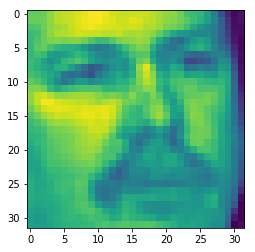

In [49]:
plt.imshow(X[0,:,:,:].reshape((image_shape[0],image_shape[1])))
print(y[0, :])

[0. 1.]


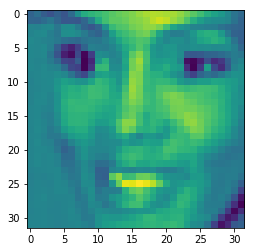

In [50]:
plt.imshow(X[-1,:,:,:].reshape((image_shape[0],image_shape[1])))
print(y[-1, :])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

In [52]:
print('X train shape:', X_train.shape)
print('X test shape:', X_test.shape)

print('y train shape:', y_train.shape)
print('y test shape:', y_test.shape)

X train shape: (11848, 32, 32, 1)
X test shape: (1317, 32, 32, 1)
y train shape: (11848, 2)
y test shape: (1317, 2)


In [53]:
def batch_gen(data, labels, batch_size):
    
    for batch_num in range(data.shape[0] // batch_size):
        
        batch_data = data[batch_num * batch_size : batch_num * batch_size + batch_size]
        batch_labels = labels[batch_num * batch_size : batch_num * batch_size + batch_size]
    
        yield batch_data, batch_labels

In [54]:
for batch in batch_gen(X_train, y_train, 1000):
    print(batch[0].shape, batch[1].shape)

(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)
(1000, 32, 32, 1) (1000, 2)


In [55]:
def conv_layer(in_tensors, kernel_size, output_depth):
    
    w = tf.get_variable('conv_w', [kernel_size, kernel_size, in_tensors.get_shape()[3], output_depth], tf.float32, tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('conv_b', [output_depth, ], tf.float32, tf.constant_initializer(0.0))
    return tf.nn.relu(tf.nn.conv2d(in_tensors, w, [1,1,1,1], 'SAME') + b)

In [56]:
def maxpool_layer(in_tensors, kernel_size):
    return tf.nn.max_pool(in_tensors, [1, kernel_size, kernel_size, 1], [1,1,1,1], 'SAME')

In [57]:
def dropout(in_tensors, keep_proba, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba), lambda: in_tensors)

In [58]:
def fc_without_activation_layer(in_tensors, n_units):
    
    w = tf.get_variable('fc_w', [in_tensors.get_shape()[1], n_units], tf.float32, tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('fc_b', [n_units, ], tf.float32, tf.constant_initializer(0.0))
    
    return tf.matmul(in_tensors, w) + b

In [59]:
def fc_layer(in_tensors, n_units):
    return tf.nn.relu(fc_without_activation_layer(in_tensors, n_units))

In [60]:
def model(in_tensors, is_training):
    
    with tf.variable_scope('l1'):
        l1 = maxpool_layer(conv_layer(in_tensors, 3, 32), 2)
        l1_out = dropout(l1, 0.8, is_training)
        
    with tf.variable_scope('l2'):
        l2 = maxpool_layer(conv_layer(l1_out, 3, 64), 2)
        l2_out = dropout(l2, 0.8, is_training)
        
    with tf.variable_scope('flatten'):
        l2_out_flat = tf.layers.flatten(l2_out)
        
    with tf.variable_scope('l3'):
        l3 = fc_layer(l2_out_flat, 1024)
        l3_out = dropout(l3, 0.6, is_training)
        
    with tf.variable_scope('out'):
        out_tensors = fc_without_activation_layer(l3_out, num_classes)
        
    return out_tensors

In [61]:
def train_model(X_train, y_train, X_test, y_test, learning_rate, num_epochs, batch_size):
    
    X_batch = tf.placeholder(tf.float32, shape = (None, image_shape[0], image_shape[1], 1))
    y_batch = tf.placeholder(tf.float32, shape = (None, num_classes))
    is_training = tf.placeholder(tf.bool)
    
    logits = model(X_batch, is_training)
    
    out_y_pred = tf.nn.softmax(logits)
    
    loss_score = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_batch)
    loss = tf.reduce_mean(loss_score)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(num_epochs):
            print('epoch = ', epoch)
            train_loss = []
            for batch in batch_gen(X_train, y_train, batch_size):
                feed_dict = {X_batch: batch[0], y_batch: batch[1], is_training: True}
                _, tf_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
                train_loss.append(tf_loss)
            print('train loss:', np.mean(train_loss))
            
        print('TEST SET PERFORMANCE')
        
        #X_test = X_test[:128]
        #y_test = y_test[:128]
        
        y_test_pred, test_loss = sess.run([out_y_pred, loss], feed_dict = {X_batch: X_test, y_batch: y_test, is_training: False})
        
        print('test loss:', test_loss)
        
        y_test_pred_classified = np.argmax(y_test_pred, axis = 1).astype(np.int32)
        y_test_true_classified = np.argmax(y_test, axis = 1).astype(np.int32)
        
        print('test score:', (np.sum(y_test_pred_classified == y_test_true_classified) / len(y_test_true_classified)) * 100)
        

In [ ]:
tf.reset_default_graph()

train_model(X_train, y_train, X_test, y_test, 0.001, 30, 32)

epoch =  0
train loss: 0.61777234
epoch =  1
train loss: 0.31202
epoch =  2
train loss: 0.27817312
epoch =  3
train loss: 0.26011318
epoch =  4
train loss: 0.24470021
epoch =  5
train loss: 0.2379143
epoch =  6
train loss: 0.22149222
epoch =  7
train loss: 0.21422927
epoch =  8
train loss: 0.20148501
epoch =  9
train loss: 0.19328786
epoch =  10
train loss: 0.1911144
epoch =  11
train loss: 0.18054204
epoch =  12
train loss: 0.17009927
epoch =  13
train loss: 0.16255344
epoch =  14
train loss: 0.15495624
epoch =  15
train loss: 0.1518541
epoch =  16
train loss: 0.13864008
epoch =  17
train loss: 0.12969397
epoch =  18
train loss: 0.12652658
epoch =  19
train loss: 0.116720065
epoch =  20
train loss: 0.111709654
epoch =  21
train loss: 0.104386084
epoch =  22
train loss: 0.10291667
epoch =  23
train loss: 0.09886799
epoch =  24
train loss: 0.09709074
epoch =  25
train loss: 0.09177878
epoch =  26
train loss: 0.082362324
epoch =  27
train loss: 0.08258991
epoch =  28
train loss: 0.072371